In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
import psycopg2
import pickle

ubuntu=True

con = None

if ubuntu: 
    con = psycopg2.connect(database='mountainproject', password='kepler31', user='devin', port=5432, host='/var/run/postgresql/')
else:
    con = psycopg2.connect(database='mountainproject', user='User')
cur = con.cursor()
con.autocommit = True

In [80]:
data_set = 'star35'
useTFIDF = True
verbose = True

#Get raw data together

In [81]:
df_obs = pd.read_csv(data_set+'_observed_features.csv')
df_obs = df_obs.set_index('Climb')

q= '''
    SELECT climb_id, comment
    FROM comments;
    '''
cur.execute(q)
df_com = pd.DataFrame(cur.fetchall())
df_com.columns = ['climb_id', 'comments']
df_com.head()

comments_series = df_com.groupby(df_com.climb_id)['comments'].agg(lambda col: ' '.join(col))
comments_count = df_com.groupby(df_com.climb_id).count()
if useTFIDF:
    comments_series = df_com.groupby(df_com.climb_id)['comments'].agg(lambda col: ' '.join(col))
    df_obs= df_obs.join(comments_series)

df_raw = df_obs.join(comments_count, rsuffix='_count')

with open('df_raw_'+data_set+'.p','w') as f:
        pickle.dump(df_raw, f)

if verbose:
    print df_raw.head()

                location  rating  rating_dif  star_votes  stars  \
Climb                                                             
105718186           Utah    21.0           1         154    4.9   
105741011          Idaho    14.5           0         164    3.8   
105741116           Utah    24.0           0         101    4.1   
105959353  New Hampshire    22.0           0         106    3.9   
105804868       New York    13.0           0          75    3.6   

                 sub_location   type  \
Climb                                  
105718186  Zion National Park   Trad   
105741011       City of Rocks   Trad   
105741116        Maple Canyon  Sport   
105959353              Rumney  Sport   
105804868           The Gunks   Trad   

                                                    comments  comments_count  
Climb                                                                         
105718186  best three pitch route in zion. pay attention ...              20  
105741011  A

##TFIDF on comments

In [70]:
if useTFIDF:
    n_samples = 2000
    n_features = 1000
    n_topics = 4
    n_top_words = 10
    df_comment = pd.DataFrame(df_raw.comment).fillna('')


    #Make vectorizer and make sparse matrix of words
    comment_vectorizer = TfidfVectorizer(max_df=0.9, 
                                         min_df=0.05, 
                                         max_features=n_features,
                                         stop_words='english')
    comment_tfidf = comment_vectorizer.fit_transform(df_comment.comment)


    #Split the data and rain the model
    com_train, com_test, y_train, y_test = \
                        train_test_split(comment_tfidf,
                                         df_raw.stars, 
                                         test_size=0.2, 
                                         random_state=42)

    com_clas = RandomForestRegressor(n_estimators=200,
                                     n_jobs=-1).fit(com_train, 
                                                     y_train,)

    #Make new dataframe from tfidf predictions
    df_tfidf_pred = pd.DataFrame(
        com_clas.predict(
        comment_vectorizer.transform(df_comment.comment)
        )
        ).set_index(df_comment.index)
    df_tfidf_pred.columns=['tf_score']

In [35]:
if useTFIDF:
    if verbose:
    #Show results of model in predicting star rating

        com_y_pred = com_clas.predict(com_test)
        print "Mean Absolute Error:", mean_absolute_error(y_test, com_y_pred)
        print "Mean Squared Error:", mean_squared_error(y_test, com_y_pred)
        print ' '
        print df_tfidf_pred.head()

        n_words = 20
        features = comment_vectorizer.get_feature_names()
        feature_df = pd.DataFrame(com_clas.feature_importances_, index=features)
        feature_df.sort(0, inplace=True)
        feature_df.iloc[:n_words].plot(kind="barh",
                                       figsize=(8,10))
        legend = plt.legend()
        legend.remove()
        plt.xlabel('Word Importance')
        plt.show()

##Dummify and drop catagorical columns.

In [36]:
def dummify(df, col_names, drop_cols):
    #Make dummy columns from catagorical vars, and drop original
    for col_name in col_names:
        df = pd.concat([df, pd.get_dummies(df[col_name])], axis = 1).drop(col_name,1)
    for col in drop_cols:
        df=df.drop(col, 1)
    
    return df


In [37]:
df_raw.columns

Index([u'location', u'rating', u'rating_dif', u'star_votes', u'stars',
       u'sub_location', u'type', u'comment'],
      dtype='object')

In [38]:
to_dum = ('type', 'sub_location')
to_drop = ['comment', 'location']
df = dummify(df_raw, to_dum, to_drop)

if useTFIDF:    
    df = pd.concat([df, df_tfidf_pred], axis=1)
if verbose:
    print df.head()

           rating  rating_dif  star_votes  stars  Sport  TR  Trad  \
Climb                                                               
105834134   22.75         0.0           6    3.5      0   0     1   
106181256   19.50         1.5          12    3.1      0   0     1   
105920111   17.50         0.0          13    2.9      1   0     0   
106208618   13.00         0.0          24    3.1      0   0     1   
105718117   28.00         0.5          45    4.9      1   0     0   

           *NH Ice and Alpine Climbing  Acadia National Park  Adirondacks  \
Climb                                                                       
105834134                            0                     0            0   
106181256                            0                     0            0   
105920111                            0                     0            0   
106208618                            0                     0            0   
105718117                            0                

In [39]:
targ = 'stars'
y = df[targ]
X = df.drop(targ, 1).fillna(0)

In [40]:
clas = RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [42]:
clas.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [43]:
clas.transform(X).shape

(13675, 19)

In [44]:
y_pred = clas.predict(X_test)

print mean_absolute_error(y_test, y_pred)
print mean_squared_error(y_test, y_pred)

0.433520290283
0.303941327638


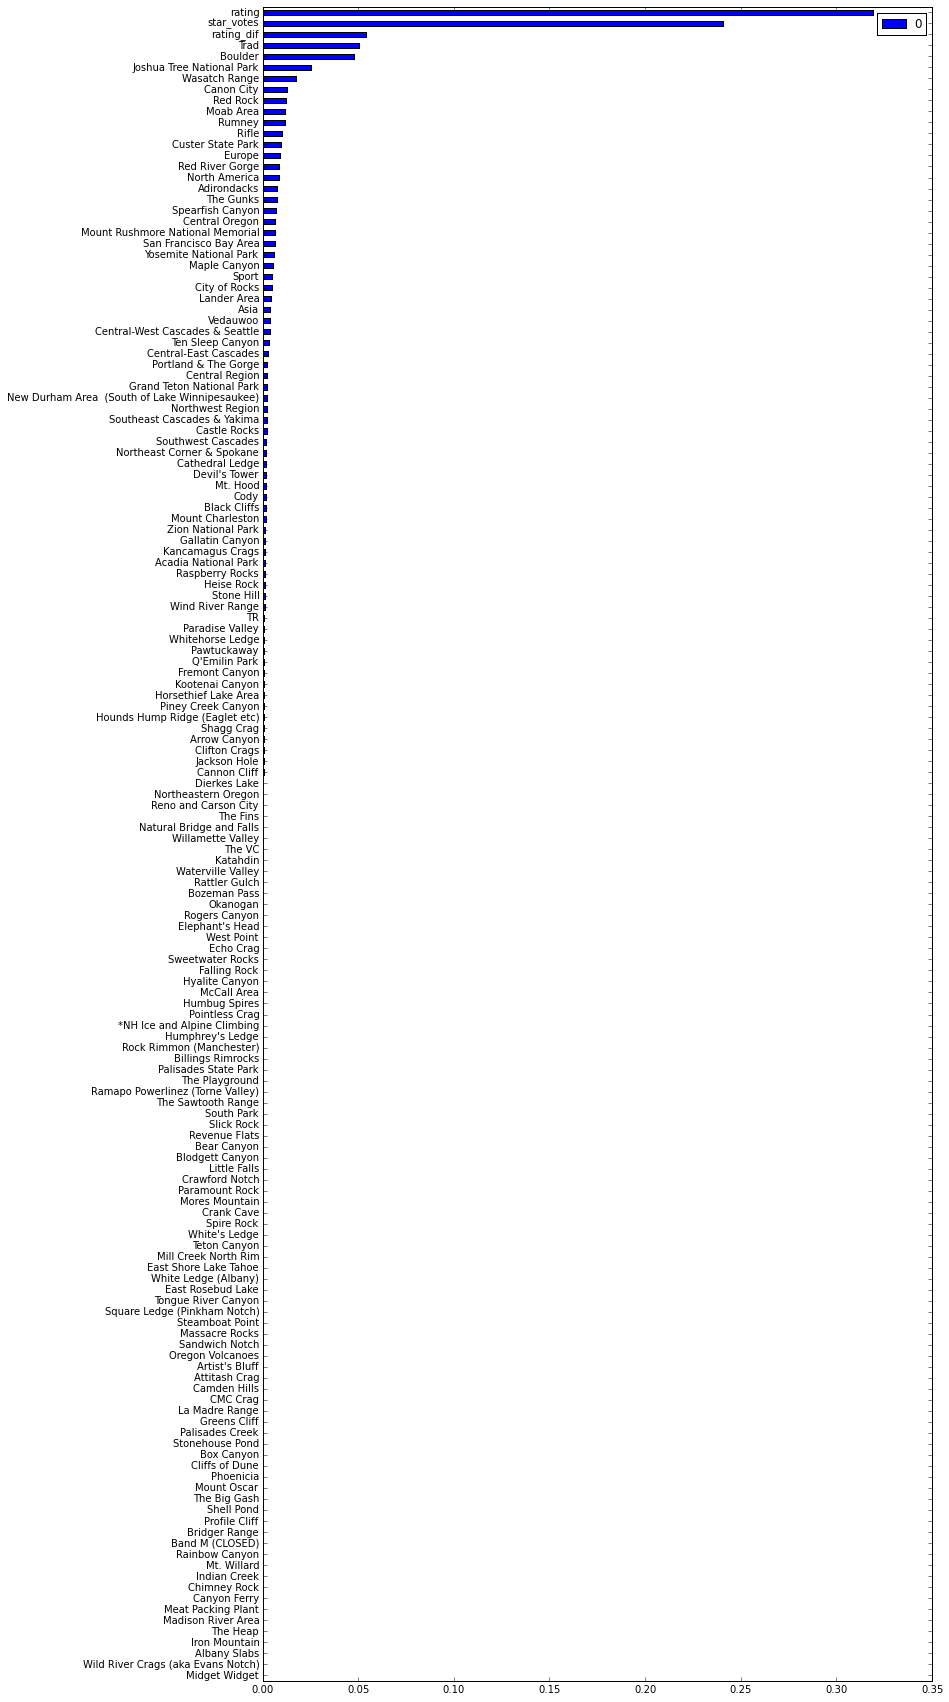

In [45]:
features = X.columns
feature_df = pd.DataFrame(clas.feature_importances_, index=features)
feature_df.sort(0, inplace=True)
# plt.figure(figsize=(20,20))
feature_df.plot(kind="barh", figsize=(12,30))
plt.show()

##Make a sample case

In [46]:
df_raw.columns

Index([u'location', u'rating', u'rating_dif', u'star_votes', u'stars',
       u'sub_location', u'type', u'comment'],
      dtype='object')

In [47]:


df_raw.loc[df_raw['sub_location']=='The Gunks'].loc[df_raw['rating']>17].loc[df_raw['type'] == 'Trad']

,location,rating,rating_dif,star_votes,stars,sub_location,type,comment
Climb,,,,,,,,
105829266,New York,17.5,0.0,66,3.9,The Gunks,Trad,11
105799049,New York,20.0,0.0,74,3.7,The Gunks,Trad,15
105829767,New York,20.0,0.0,61,4.4,The Gunks,Trad,6
105899738,New York,19.5,0.0,33,4.0,The Gunks,Trad,2
106391802,New York,22.5,-0.5,9,2.9,The Gunks,Trad,8
107333984,New York,24.5,0.5,5,3.6,The Gunks,Trad,NaN
105799072,New York,20.0,0.5,48,4.5,The Gunks,Trad,13
106146799,New York,18.0,0.5,27,3.3,The Gunks,Trad,4
106692049,New York,19.0,0.0,7,3.6,The Gunks,Trad,1


In [48]:
def compare_change_sub_location(climb_id, origin, dest):
    climb_test = df.loc[climb_id].copy()
    print "Actual stars for climb:", y.loc[climb_id]
    climb_test.drop('stars', inplace=True)

    print "Model prediction of climb:", \
        clas.predict(X.loc[climb_id])[0],\
        origin
    climb_test = X.loc[climb_id].copy()
    climb_test[origin]=0
    climb_test[dest]=1
    print "Model prediction of climb if it were elsewhere:\n", \
        clas.predict(climb_test)[0], \
        dest



print '''
Example of hard sport climb:
Rumney is known for having awesome hard sport climbs, 
while Boulder is not.  
'''
compare_change_sub_location(105753604, 'Boulder', 'Rumney')



print '''
Example of easy Trad climb,
where the Gunks is better than Boulder:
The Gunks are known for their awesome and easy
sport routes.  Boulder is not.
'''

compare_change_sub_location(105748705, 'Boulder', 'The Gunks')


print '''
Example of hard Trad climb, 
where the Boulder is better than the Gunks:
Boulder is known for its awesome and harder
trad routes.  The Gunks are not.
'''
compare_change_sub_location(106391802, 'The Gunks', 'Boulder')




Example of hard sport climb:
Rumney is known for having awesome hard sport climbs, 
while Boulder is not.  

Actual stars for climb: 3.6
Model prediction of climb: 3.5874 Boulder
Model prediction of climb if it were elsewhere:
4.1585 Rumney

Example of easy Trad climb,
where the Gunks is better than Boulder:
The Gunks are known for their awesome and easy
sport routes.  Boulder is not.

Actual stars for climb: 3.5
Model prediction of climb: 3.37 Boulder
Model prediction of climb if it were elsewhere:
3.99466666667 The Gunks

Example of hard Trad climb, 
where the Boulder is better than the Gunks:
Boulder is known for its awesome and harder
trad routes.  The Gunks are not.

Actual stars for climb: 2.9
Model prediction of climb: 3.078 The Gunks
Model prediction of climb if it were elsewhere:
3.0313 Boulder


In [49]:
climb_ave = ((df.loc[105756532]+df.iloc[6])/2 ).drop('stars')
climb_ave

rating                                18.75
rating_dif                             0.25
star_votes                            61.50
Sport                                  1.00
TR                                     0.00
Trad                                   0.00
*NH Ice and Alpine Climbing            0.00
Acadia National Park                   0.00
Adirondacks                            0.00
Albany Slabs                           0.00
Arrow Canyon                           0.00
Artist's Bluff                         0.00
Asia                                   0.00
Attitash Crag                          0.00
Band M (CLOSED)                        0.00
Bear Canyon                            0.00
Billings Rimrocks                      0.00
Black Cliffs                           0.00
Blodgett Canyon                        0.00
Boulder                                0.50
Box Canyon                             0.00
Bozeman Pass                           0.00
Bridger Range                   

In [50]:
clas.predict(climb_ave)

array([ 3.605])

In [51]:
climb_ave['Moab Area'] = 0.
climb_ave['Zion National Park'] = 0.
climb_ave['Wasatch Range'] = 1.

In [52]:
clas.predict(climb_ave)

array([ 3.321])

##Scratch work

In [53]:
df_raw[df_raw.rating_dif != 0].sort(['rating_dif'], ascending=1)

,location,rating,rating_dif,star_votes,stars,sub_location,type,comment
Climb,,,,,,,,
105722767,California,16.0,-15.0,19,3.2,Joshua Tree National Park,Trad,11
106494791,Kentucky,8.5,-4.5,6,2.3,Red River Gorge,Trad,3
105750976,Colorado,3.5,-4.0,38,3.3,Boulder,Trad,6
105758925,Colorado,3.5,-4.0,7,3.1,Boulder,Trad,1
108330159,Oregon,14.5,-3.5,6,3.2,Central Oregon,Trad,3
106455666,South Dakota,11.5,-3.5,9,3.1,Mount Rushmore National Memorial,Sport,1
105723556,California,13.0,-3.0,33,2.9,Joshua Tree National Park,Trad,12
105752806,Colorado,22.0,-3.0,7,3.1,Canon City,Sport,4
105762552,Colorado,18.0,-3.0,7,2.4,Boulder,Trad,5
